____
__Universidad de San Andrés__<br/>
__Machine Learning__<br/>
__Modelado probabilistico de audios de ballenas y estudio de transfer learning__<br/>
__Martin Bianchi y Federico Gutman__
____

### Importamos las librerías necesarias

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from IPython.display import Audio, display
from sklearn.decomposition import PCA

### NOTAS
- ver repo para preprocesar espectrogrma
    - ver de reducir el y-lim del spectrograma -> averiguar bien entre que frecuencias se mueven los cantos de ballena
- cambiar noise a no right whale
- cambiar el idioma a español


### Definimos algunas variables globales

In [2]:
SEED = 3            # semilla para reproductibilidad
SR = 2000           # sampling rate
N_FFT = 256         # tamaño de la ventana
HOP_LENGTH = 64     # salto entre frames
N_MELS = 50         # frequency bins (resolución)
MAX_FREQ = 600      # máxima frecuencia para los espectrogramas --ponerlo en 500--

### Cargamos los datos y los visualizamos

In [3]:
def load_data(train_path:str, test_path:str, labels_path:str, sampling_rate=SR):
    test_files = [f for f in os.listdir(test_path) if f.endswith('.aiff')]
    labels_df = pd.read_csv(labels_path)

    audio_df = labels_df.copy()
    audio_df['filepath'] = audio_df['clip_name'].apply(lambda x: os.path.join(train_path, x))
    audio_df['audio'] = audio_df['filepath'].apply(lambda path: librosa.load(path, sr=sampling_rate)[0])

    return audio_df, labels_df, test_files

def display_random_samples(dataset:pd.DataFrame, sampling_rate=SR):
    np.random.seed(SEED)

    # SAMPLES
    whale_sample = dataset[dataset['label'] == 1].sample(5)['audio']
    noise_sample = dataset[dataset['label'] == 0].sample(5)['audio']

    # AUDIO
    print('right whale call random audio sample')
    display(Audio(np.array(whale_sample.iloc[0]), rate=sampling_rate*1.5))
    print('\nno whale random audio sample')
    display(Audio(np.array(noise_sample.iloc[0]), rate=sampling_rate*1.5))

    # SOUND-WAVE
    fig, axes = plt.subplots(2, 5, figsize=(15, 5))

    for i in range(5):
        axes[0, i].plot(np.array(whale_sample.iloc[i]))
        axes[0, i].set_title('Whale')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        axes[1, i].plot(np.array(noise_sample.iloc[i]), color='#FF6961')
        axes[1, i].set_title('No Whale')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

    plt.tight_layout()
    plt.show()

    # MULTIPLE SPECTROGRAMS
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(5):
        whale_sample_spectrogram = get_melspectrogram(whale_sample.iloc[i])
        img0 = librosa.display.specshow(whale_sample_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[0, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[0, i].set_title('Whale')
        axes[0, i].set_ylim([0, MAX_FREQ])
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        axes[0, i].set_xlabel('')
        axes[0, i].set_ylabel('')

        noise_sample_spectrogram = get_melspectrogram(noise_sample.iloc[i])
        img1 = librosa.display.specshow(noise_sample_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[1, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[1, i].set_title('No Whale')
        axes[1, i].set_ylim([0, MAX_FREQ])
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        axes[1, i].set_xlabel('')
        axes[1, i].set_ylabel('')

    plt.tight_layout()
    plt.show()

    # TWO SPECTROGRAMS
    whale_sample2 = dataset[dataset['label'] == 1].sample(1, random_state=SEED+1)['audio']
    noise_sample2 = dataset[dataset['label'] == 0].sample(1, random_state=SEED+1)['audio']
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 3))

    whale_sample2_spectrogram = get_melspectrogram(whale_sample2.iloc[0])
    img0 = librosa.display.specshow(whale_sample2_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[0], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[0].set_title('Whale')
    axes[0].set_ylim([0, MAX_FREQ])
    fig.colorbar(img0, ax=axes[0], format="%+2.0f dB")

    noise_sample2_spectrogram = get_melspectrogram(noise_sample2.iloc[0])
    img1 = librosa.display.specshow(noise_sample2_spectrogram, sr=sampling_rate, hop_length=HOP_LENGTH, ax=axes[1], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[1].set_title('No Whale')
    axes[1].set_ylim([0, MAX_FREQ])
    fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

    plt.tight_layout()
    plt.show()

def normalize(dataset:pd.DataFrame, column:str):
    dataset[column] = dataset[column].apply(lambda x: x / np.max(np.abs(x)))

def get_signal_energy(dataset:pd.DataFrame, column:str):
    energy = []
    df = dataset.copy()
    for x in df[column]:
        energy.append(np.sum(np.square(x)))
    df['energy'] = energy

    return df

def get_melspectrogram(sample:pd.DataFrame, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_spectrogram = librosa.feature.melspectrogram(y=np.array(sample), sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=MAX_FREQ)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return mel_spectrogram

def get_all_mel_spectrograms(audio_df, sampling_rate=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_specs = []
    for audio in audio_df['audio']:
        mel = get_melspectrogram(audio, sampling_rate, n_fft, hop_length, n_mels)
        mel_specs.append(mel.flatten())
    return np.array(mel_specs)

def show_class_balance(dataset:pd.DataFrame):
    plt.figure(figsize=(5, 4))
    ax = sns.countplot(
        x='label',
        data=dataset,
        palette={0: '#FF6961', 1: plt.rcParams['axes.prop_cycle'].by_key()['color'][0]},
        hue='label',
        legend=False
    )
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Noise', 'Whale'])
    ax.legend(['Noise', 'Whale'], title='Class')
    plt.show()

def extract_time_acoustic_features(dataset:pd.DataFrame):
    new_features = []
    for audio in dataset['audio']:
        audio_np = np.array(audio)
        acoustic_features = {
            'rms_energy': np.mean(librosa.feature.rms(y=audio_np)),
            'zcr': np.mean(librosa.feature.zero_crossing_rate(y=audio_np)),
        }
        new_features.append(acoustic_features)
    features_df = pd.DataFrame(new_features)
    return features_df

def extract_frequency_acoustic_features(dataset:pd.DataFrame):
    new_features = []
    for audio in dataset['audio']:
        audio_np = np.array(audio)
        acoustic_features = {
            'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=audio_np)),
            'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=audio_np)),
            'spectral_rolloff': np.mean(librosa.feature.spectral_rolloff(y=audio_np)),
            'spectral_flatness': np.mean(librosa.feature.spectral_flatness(y=audio_np))
        }
        new_features.append(acoustic_features)
    features_df = pd.DataFrame(new_features)
    return features_df

def extract_acoustic_features(dataset:pd.DataFrame):
    time_features = extract_time_acoustic_features(dataset)
    frequency_features = extract_frequency_acoustic_features(dataset)

    new_df = pd.concat([dataset.reset_index(drop=True), time_features], axis=1)
    new_df = pd.concat([new_df.reset_index(drop=True), frequency_features], axis=1)
    
    return new_df

def display_features_boxplots(audio_features_df:pd.DataFrame):
    time_features = ['rms_energy', 'zcr']
    freq_features = ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'spectral_flatness']

    # TIME
    fig, axes = plt.subplots(1, len(time_features), figsize=(5 * len(time_features), 5))
    if len(time_features) == 1:
        axes = [axes]
    for i, feature in enumerate(time_features):
        sns.boxplot(x='label', y=feature, data=audio_features_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{feature} by Class')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Noise', 'Whale'])

    plt.suptitle('Time Domain Features by Class')
    plt.tight_layout()
    plt.show()

    # FREQUENCY
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    for i, feature in enumerate(freq_features):
        sns.boxplot(x='label', y=feature, data=audio_features_df, ax=axes[i], showfliers=False)
        axes[i].set_title(f'{feature} by Class')
        axes[i].set_xlabel('Class')
        axes[i].set_xticks([0, 1])
        axes[i].set_xticklabels(['Noise', 'Whale'])

    plt.suptitle('Frequency Domain Features by Class')
    plt.tight_layout()
    plt.show()

def plot_pca(dataset:pd.DataFrame, pca_arr):
    plt.figure(figsize=(8,6))
    scatter = sns.scatterplot(
        x=pca_arr[:,0], 
        y=pca_arr[:,1], 
        hue=dataset['label'], 
        palette={0: '#FF6961', 1: '#1f77b4'}
    )
    plt.title('PCA of Mel Spectrograms')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    # Fix legend labels and colors
    handles, _ = scatter.get_legend_handles_labels()
    scatter.legend(handles=handles, title='Class', labels=['Noise', 'Whale'])
    plt.show()

def plot_average_spectrograms(audio_df:pd.DataFrame):
    whale_spectrograms = []
    noise_spectrograms = []
    for audio, label in zip(audio_df['audio'], audio_df['label']):
        spectrogram = get_melspectrogram(audio)
        if label == 1:
            whale_spectrograms.append(spectrogram)
        else: 
            noise_spectrograms.append(spectrogram)
    
    whale_spectrograms = np.array(whale_spectrograms)
    noise_spectrograms = np.array(noise_spectrograms)

    whale_average_spectrogram = whale_spectrograms.mean(axis=0)
    noise_average_spectrogram = noise_spectrograms.mean(axis=0)
    average_differences_spectrogram = whale_average_spectrogram - noise_average_spectrogram

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    img0 = librosa.display.specshow(whale_average_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[0], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[0].set_title('Whale Call Average Spectrogram', pad=20)
    axes[0].set_ylim([0, MAX_FREQ])
    # axes[0].set_xticks([])
    # axes[0].set_yticks([])
    fig.colorbar(img0, ax=axes[0], format="%+2.0f dB")

    img1 = librosa.display.specshow(noise_average_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[1], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[1].set_title('No Whale Call Average Spectrogram', pad=20)
    axes[1].set_ylim([0, MAX_FREQ])
    # axes[1].set_xticks([])
    # axes[1].set_yticks([])
    fig.colorbar(img1, ax=axes[1], format="%+2.0f dB")

    img2 = librosa.display.specshow(average_differences_spectrogram, sr=SR, hop_length=HOP_LENGTH, ax=axes[2], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
    axes[2].set_title('Average Differences Spectrogram', pad=20)
    axes[2].set_ylim([0, MAX_FREQ])
    # axes[2].set_xticks([])
    # axes[2].set_yticks([])
    fig.colorbar(img2, ax=axes[2], format="%+2.0f dB")

    # 3 subplots -> average spectrogram whale, noise, resto y consigo diferencias
    plt.tight_layout()
    plt.show()


In [4]:
train_dir = 'data/whale-detection-challenge/data/train'
test_dir = 'data/whale-detection-challenge/data/test'
labels_dir = 'data/whale-detection-challenge/data/train.csv'

audio_df, labels_df, test_files = load_data(train_dir, test_dir, labels_dir)

right whale call random audio sample



no whale random audio sample


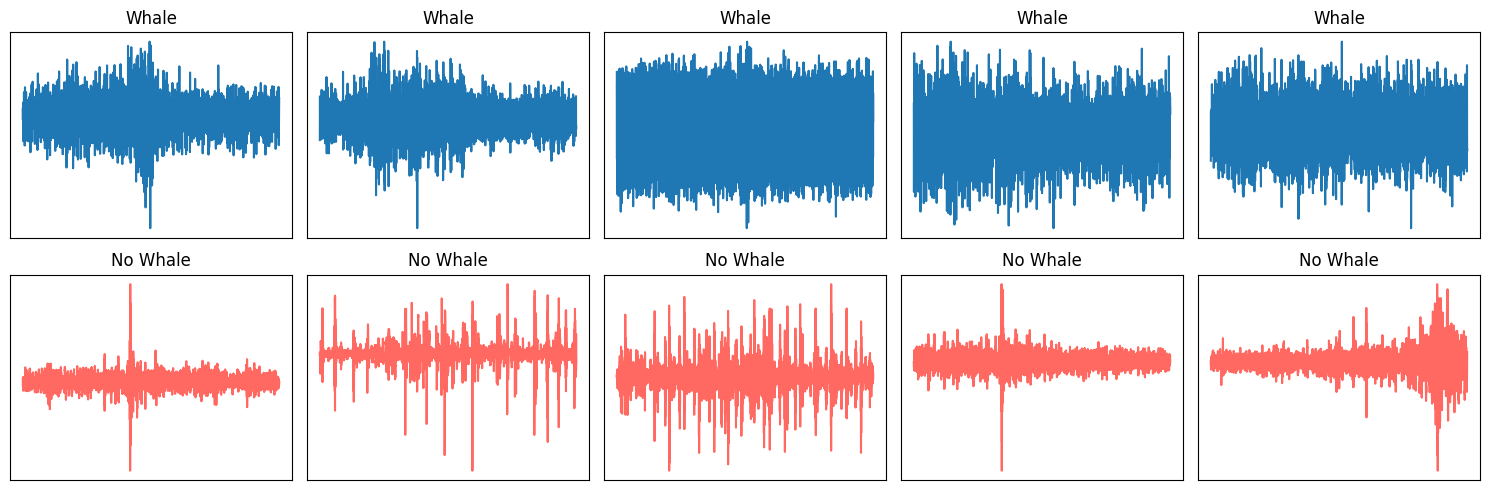

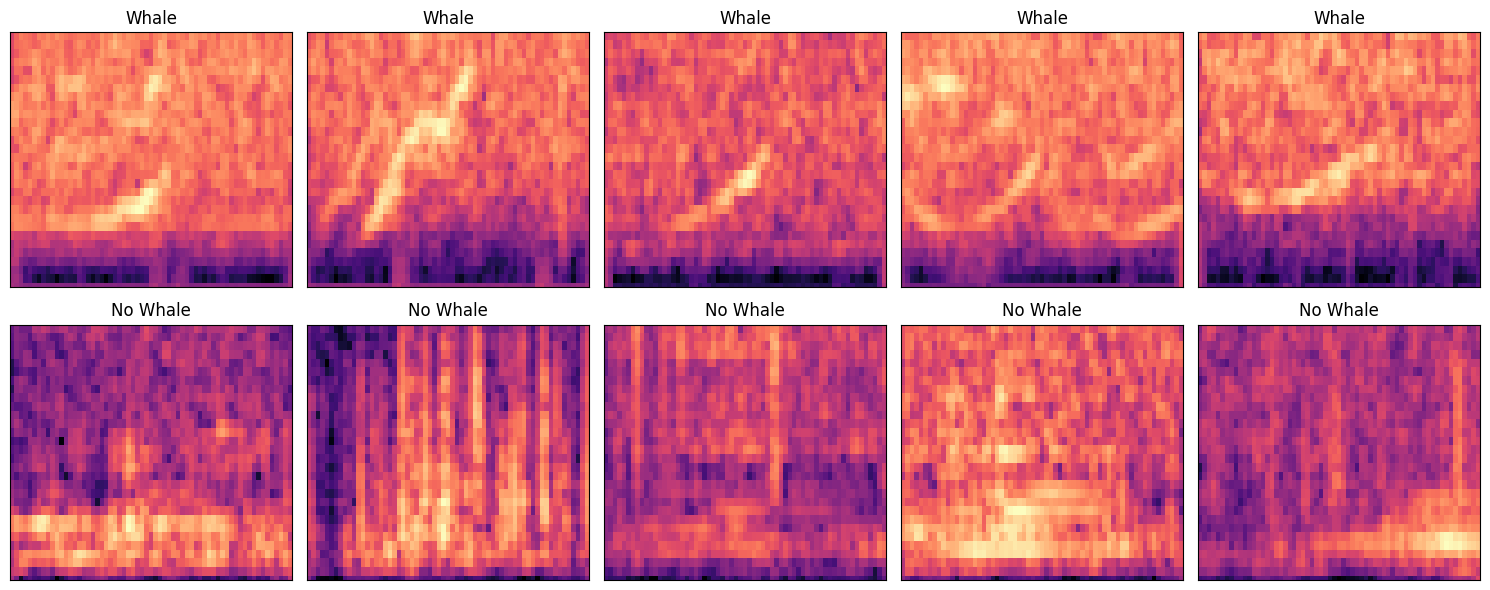

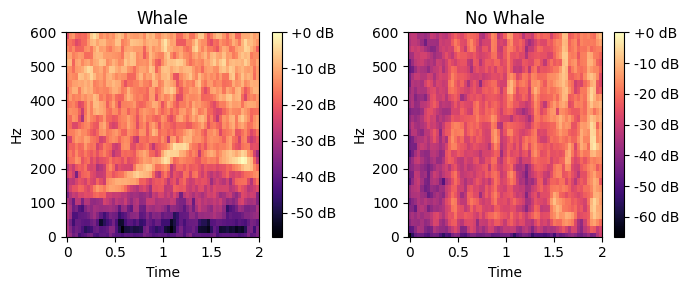

In [5]:
normalize(audio_df, 'audio')
display_random_samples(audio_df)

### Hacemos un análisis exploratorio de los datos

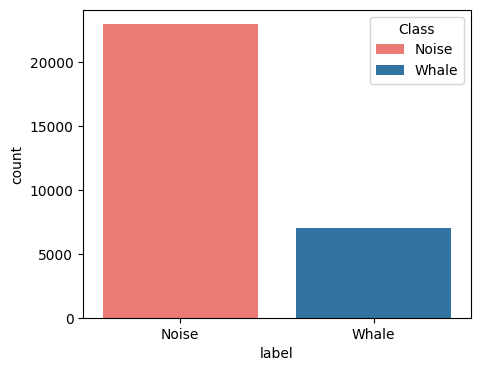

In [ ]:
show_class_balance(audio_df)

In [ ]:
# plot_average_spectrograms(audio_df)

KeyboardInterrupt: 

In [8]:
audio_features_df = extract_acoustic_features(audio_df)
# display_features_boxplots(audio_features_df)

In [9]:
# EXPERIMENTO PCA
flattened_mel_spectrogram = get_all_mel_spectrograms(audio_df)
# pca = PCA(n_components=2)
# spec_pca = pca.fit_transform(flattened_mel_spectrogram)

# plot_pca(audio_df, spec_pca)

### Arrancamos el modelado

### Importamos las librerías necesarias

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, ParameterGrid, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, roc_curve, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

In [11]:
def normalize_spectrogram(spec, global_min, global_max):
    norm_spec = (spec - global_min) / (global_max - global_min + 1e-8)
    return norm_spec

def denormalize_spectrogram(norm_spec, min_val, max_val):
    return norm_spec * (max_val - min_val + 1e-8) + min_val

def compute_global_min_max(audio_df):
    whale_specs = [get_melspectrogram(audio) for audio, label in zip(audio_df['audio'], audio_df['label']) if label == 1]
    global_min = np.min([spec.min() for spec in whale_specs])
    global_max = np.max([spec.max() for spec in whale_specs])
    return global_min, global_max

def get_class_weights(y):
    weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    return torch.tensor(weights, dtype=torch.float32)

def get_data_loaders(train_df):
    X = get_all_mel_spectrograms(train_df)
    y = train_df['label'].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128)

    return train_loader, val_loader



### Creamos las clases y funciones necesarias para los modelos de clasificación

In [74]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers=[256, 128, 64], output_dim=2):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim

        for hidden_layer in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_layer))
            layers.append(nn.ReLU())
            prev_dim = hidden_layer
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def forward(self, x):
        return self.model(x)
    
    def train_model(self, train_loader, val_loader, epochs=50, lr=0.001, weight_decay=1e-5, early_stopping_patience=None):
        self.to(self.device)
        y_train = train_loader.dataset.tensors[1].cpu().numpy().flatten()
        loss_function = nn.CrossEntropyLoss(weight=get_class_weights(y_train).to(self.device))
        optimizer = optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        train_losses = []
        val_losses = []
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            self.train()
            running_loss = 0.0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
            avg_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)

            val_loss, val_acc = self.evaluate(val_loader, return_metrics=True)
            val_losses.append(val_loss)

            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

            # Early stopping
            if early_stopping_patience is not None:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print("Early stopping triggered.")
                        break

        return train_losses, val_losses

    def evaluate(self, val_loader, return_metrics=False):
        self.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        loss_function = nn.CrossEntropyLoss()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self(inputs)
                loss = loss_function(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        avg_val_loss = val_loss / len(val_loader.dataset)
        accuracy = 100 * correct / total
        if return_metrics:
            return avg_val_loss, accuracy
        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
# ESTO DE ABAJO NO ANDA TODAVIA PERO ES PARA YA TENERLO
def MLP_cross_val(train_loader:DataLoader, val_loader:DataLoader, input_dim:int, hidden_layers:list, output_dim:int, epochs:int, lr:list, weight_decay:list, regularization_term:list, early_stopping_patience:list):
    best_model = None
    best_val_loss = float('inf')
    best_params = None
    global_min, global_max = compute_global_min_max(train_loader.dataset)
    for lr_val in lr:
        for wd in weight_decay:
            for reg in regularization_term:
                model = MLP(input_dim, hidden_layers, output_dim)
                model.train(train_loader, val_loader, epochs=epochs, lr=lr_val, weight_decay=wd)

                # Evaluate on validation set
                val_loss = 0.0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in val_loader:
                        inputs, labels = inputs.to(model.device), labels.to(model.device)
                        outputs = model(inputs)
                        loss = nn.CrossEntropyLoss()(outputs, labels)
                        val_loss += loss.item()

                val_loss /= len(val_loader)

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = (lr_val, wd, reg)
    print(f'Best Validation Loss: {best_val_loss:.4f} with params: LR={best_params[0]}, WD={best_params[1]}, Reg={best_params[2]}')
    return best_model, best_params    

def train_random_forest(X_train, y_train, X_val, y_val):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"Validation Accuracy (Random Forest): {acc:.4f}")
    return rf

def train_gradient_boosting(X_train, y_train, X_val, y_val):
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
    gb.fit(X_train, y_train)
    preds = gb.predict(X_val)
    acc = accuracy_score(y_val, preds)
    print(f"Validation Accuracy (Gradient Boosting): {acc:.4f}")
    return gb



### Obtenemos los audios de entrenamiento

In [13]:
audio_train_df = audio_df[audio_df['clip_name'].str.contains('train')]

### Hacemos validación cruzada alternando entre una loss con pesos y cambiando la máxima frecuencia de los espectrogramas

explicar lo de las frecuencias de 500 (standard ballena) - y 600 imgs

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_mlp_with_maxfreqs(audio_train_df, MLP, get_all_mel_spectrograms, get_class_weights,
                                    max_freq_list=[500, 600, 1000], n_folds=5, patience=3,
                                    batch_size=128, learning_rate=1e-3, seed=42):

    original_max_freq = globals().get("MAX_FREQ", None)
    SEED = seed

    for max_frequency in max_freq_list:
        print(f'\n--- MAX_FREQ = {max_frequency} HZ ---')
        globals()["MAX_FREQ"] = max_frequency

        X = get_all_mel_spectrograms(audio_train_df)
        y = audio_train_df['label'].values

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)

        for weighted in [False, True]:
            print(f'\n--- WEIGHTED LOSS = {weighted} ---')
            fold_aucs = []
            fold_f1s = []

            for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
                print(f'\nFold {fold+1}/{n_folds}')
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
                y_train_tensor = torch.tensor(y_train, dtype=torch.long)
                X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
                y_val_tensor = torch.tensor(y_val, dtype=torch.long)

                train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

                mlp = MLP(X_train.shape[1]).to(device)
                if weighted:
                    weights = get_class_weights(y_train).to(device)
                    loss_function = nn.CrossEntropyLoss(weight=weights)
                else:
                    loss_function = nn.CrossEntropyLoss()
                optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)

                best_auc = 0
                counter = 0

                for epoch in range(20):
                    mlp.train()
                    for xb, yb in train_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        optimizer.zero_grad()
                        loss = loss_function(mlp(xb), yb)
                        loss.backward()
                        optimizer.step()

                    mlp.eval()
                    all_probs, all_targets = [], []
                    with torch.no_grad():
                        for xb, yb in val_loader:
                            xb = xb.to(device)
                            probs = torch.softmax(mlp(xb), dim=1)[:, 1].cpu().numpy()
                            all_probs.extend(probs)
                            all_targets.extend(yb.numpy())

                    auc = roc_auc_score(all_targets, all_probs)
                    print(f"Epoch {epoch+1} - AUC: {auc:.4f}")

                    if auc > best_auc:
                        best_auc = auc
                        counter = 0
                    else:
                        counter += 1
                        if counter >= patience:
                            print("Early stopping")
                            break

                print(f"AUC MLP final (fold {fold+1}): {best_auc:.4f}")
                y_pred = [1 if p > 0.5 else 0 for p in all_probs]
                f1 = f1_score(all_targets, y_pred)
                print(f"F1-SCORE (fold {fold+1}): {f1:.4f}")

                fold_aucs.append(best_auc)
                fold_f1s.append(f1)

            print(f'\nMean AUC over {n_folds} folds: {np.mean(fold_aucs):.4f}')
            print(f'Mean F1-Score over {n_folds} folds: {np.mean(fold_f1s):.4f}')

    if original_max_freq is not None:
        globals()["MAX_FREQ"] = original_max_freq

# train_mlp_with_maxfreqs(
#     audio_train_df=audio_train_df,
#     MLP=MLP,
#     get_all_mel_spectrograms=get_all_mel_spectrograms,
#     get_class_weights=get_class_weights,
#     max_freq_list=[500, 600, 1000],
#     n_folds=5,
#     patience=3
# )


### Preprocesamos los datos para darselos al modelo

In [75]:
X = get_all_mel_spectrograms(audio_train_df)
y = audio_train_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

batch_size = 128
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

### Entrenamos 3 clasificadores

### Entrenamos un MLP

In [76]:
mlp_torch = MLP(X_train.shape[1])
mlp_torch.to(device)
train_losses, val_losses = mlp_torch.train_model(train_loader, val_loader, epochs=20, lr=1e-3)

Epoch 1/20 | Train Loss: 0.5737 | Val Loss: 0.4710 | Val Acc: 78.17%
Epoch 2/20 | Train Loss: 0.3736 | Val Loss: 0.3338 | Val Acc: 85.13%
Epoch 3/20 | Train Loss: 0.3564 | Val Loss: 0.3346 | Val Acc: 85.20%
Epoch 4/20 | Train Loss: 0.3399 | Val Loss: 0.3339 | Val Acc: 85.25%
Epoch 5/20 | Train Loss: 0.3301 | Val Loss: 0.3491 | Val Acc: 84.38%
Epoch 6/20 | Train Loss: 0.3294 | Val Loss: 0.3822 | Val Acc: 82.80%
Epoch 7/20 | Train Loss: 0.3102 | Val Loss: 0.4193 | Val Acc: 76.85%
Epoch 8/20 | Train Loss: 0.3063 | Val Loss: 0.2979 | Val Acc: 86.28%
Epoch 9/20 | Train Loss: 0.3021 | Val Loss: 0.3348 | Val Acc: 84.18%
Epoch 10/20 | Train Loss: 0.3176 | Val Loss: 0.2762 | Val Acc: 86.22%
Epoch 11/20 | Train Loss: 0.2967 | Val Loss: 0.4317 | Val Acc: 79.63%
Epoch 12/20 | Train Loss: 0.3022 | Val Loss: 0.3330 | Val Acc: 84.58%
Epoch 13/20 | Train Loss: 0.2859 | Val Loss: 0.3330 | Val Acc: 86.10%
Epoch 14/20 | Train Loss: 0.3088 | Val Loss: 0.3795 | Val Acc: 82.20%
Epoch 15/20 | Train Loss: 0.2

In [17]:
def plot_learning_curves(train_losses, val_losses):
# poner esto adentro del modelo como plot_learning_curves
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# plot_learning_curves(train_losses, val_losses)

### Pasamos los tensores a numpy

In [18]:
X_train_np = X_train_tensor.numpy()
y_train_np = y_train_tensor.numpy()
X_val_np = X_val_tensor.numpy()
y_val_np = y_val_tensor.numpy()

### Entrenamos un Random Forest

In [19]:
# rf_model = train_random_forest(X_train_np, y_train_np, X_val_np, y_val_np)

### Entrenamos un Gradient Boosting
cambiar a xgboost

In [20]:
# gb_model = train_gradient_boosting(X_train_np, y_train_np, X_val_np, y_val_np)

### Visualizamos las curvas ROC de los modelos

In [21]:
def get_mlp_probs(model, val_loader, device):
    """Predice probabilidades de clase positiva con un MLP de PyTorch"""
    model.eval()
    probs = []
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            outputs = model(xb)
            p = F.softmax(outputs, dim=1)[:, 1]  # clase positiva
            probs.extend(p.cpu().numpy())
    return np.array(probs)

def get_model_probs_sklearn(model, X_val):
    """Predice probabilidades de clase positiva con un modelo sklearn"""
    return model.predict_proba(X_val)[:, 1]

def compute_roc(y_true, y_probs):
    """Calcula AUC, FPR y TPR"""
    auc = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    return auc, fpr, tpr

def plot_roc_curves(roc_data_dict):
    """
    Plotea curvas ROC.
    roc_data_dict: dict con keys = nombres de modelos, values = (auc, fpr, tpr)
    """
    plt.figure(figsize=(8, 6))
    for name, (auc, fpr, tpr) in roc_data_dict.items():
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# mlp_probs = get_mlp_probs(mlp_torch, val_loader, device)
# rf_probs = get_model_probs_sklearn(rf_model, X_val_np)
# gb_probs = get_model_probs_sklearn(gb_model, X_val_np)

# mlp_auc, fpr_mlp, tpr_mlp = compute_roc(y_val_np, mlp_probs)
# rf_auc, fpr_rf, tpr_rf = compute_roc(y_val_np, rf_probs)
# gb_auc, fpr_gb, tpr_gb = compute_roc(y_val_np, gb_probs)

# roc_data = {
#     "MLP": (mlp_auc, fpr_mlp, tpr_mlp),
#     "Random Forest": (rf_auc, fpr_rf, tpr_rf),
#     "Gradient Boosting": (gb_auc, fpr_gb, tpr_gb)
# }

# plot_roc_curves(roc_data)


### Entrenamos modelos generativos para data augmentation

#### Variational Autoencoder (VAE)

In [ ]:
# VARIATIONAL AUTOENCODER MODEL

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32,
                 encoder_layers=[256, 128], decoder_layers=[128, 256],
                 activation_fn=nn.ReLU):
        super().__init__()
        # Encoder
        enc = []
        prev = input_dim
        for h in encoder_layers:
            enc.append(nn.Linear(prev, h))
            enc.append(activation_fn())
            prev = h
        self.encoder = nn.Sequential(*enc)
        self.fc_mu = nn.Linear(prev, latent_dim)
        self.fc_logvar = nn.Linear(prev, latent_dim)
        # Decoder
        dec = []
        prev = latent_dim
        for h in decoder_layers:
            dec.append(nn.Linear(prev, h))
            dec.append(activation_fn())
            prev = h
        dec.append(nn.Linear(prev, input_dim))
        dec.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*dec)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def loss(self, x, x_hat, mu, logvar):
        recon = nn.functional.mse_loss(x_hat, x, reduction='mean')
        kl = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
        return recon + kl
    
def train_vae_model(X, train_loader,
                    latent_dim=32,
                    encoder_layers=[256, 128],
                    decoder_layers=[128, 256],
                    activation_fn=nn.ReLU,
                    lr=1e-3,
                    weight_decay=0.0,
                    epochs=100,
                    patience=10,
                    verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    vae = VAE(input_dim=X.shape[1],
              latent_dim=latent_dim,
              encoder_layers=encoder_layers,
              decoder_layers=decoder_layers,
              activation_fn=activation_fn).to(device)

    optimizer = optim.Adam(vae.parameters(), lr=lr, weight_decay=weight_decay)

    best_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        vae.train()
        total_loss = 0

        for xb_tuple in train_loader:
            xb = xb_tuple[0].to(device)
            x_hat, mu, logvar = vae(xb)
            loss = vae.loss(xb, x_hat, mu, logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)

        avg_loss = total_loss / len(train_loader.dataset)

        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                if verbose:
                    print("Early stopping.")
                break

    return vae, best_loss

             clip_name  label  \
0          train1.aiff      0   
1          train2.aiff      0   
2          train3.aiff      0   
3          train4.aiff      0   
4          train5.aiff      0   
...                ...    ...   
29995  train29996.aiff      0   
29996  train29997.aiff      0   
29997  train29998.aiff      0   
29998  train29999.aiff      0   
29999  train30000.aiff      0   

                                                filepath  \
0      data/whale-detection-challenge/data/train\trai...   
1      data/whale-detection-challenge/data/train\trai...   
2      data/whale-detection-challenge/data/train\trai...   
3      data/whale-detection-challenge/data/train\trai...   
4      data/whale-detection-challenge/data/train\trai...   
...                                                  ...   
29995  data/whale-detection-challenge/data/train\trai...   
29996  data/whale-detection-challenge/data/train\trai...   
29997  data/whale-detection-challenge/data/train\trai...   
299

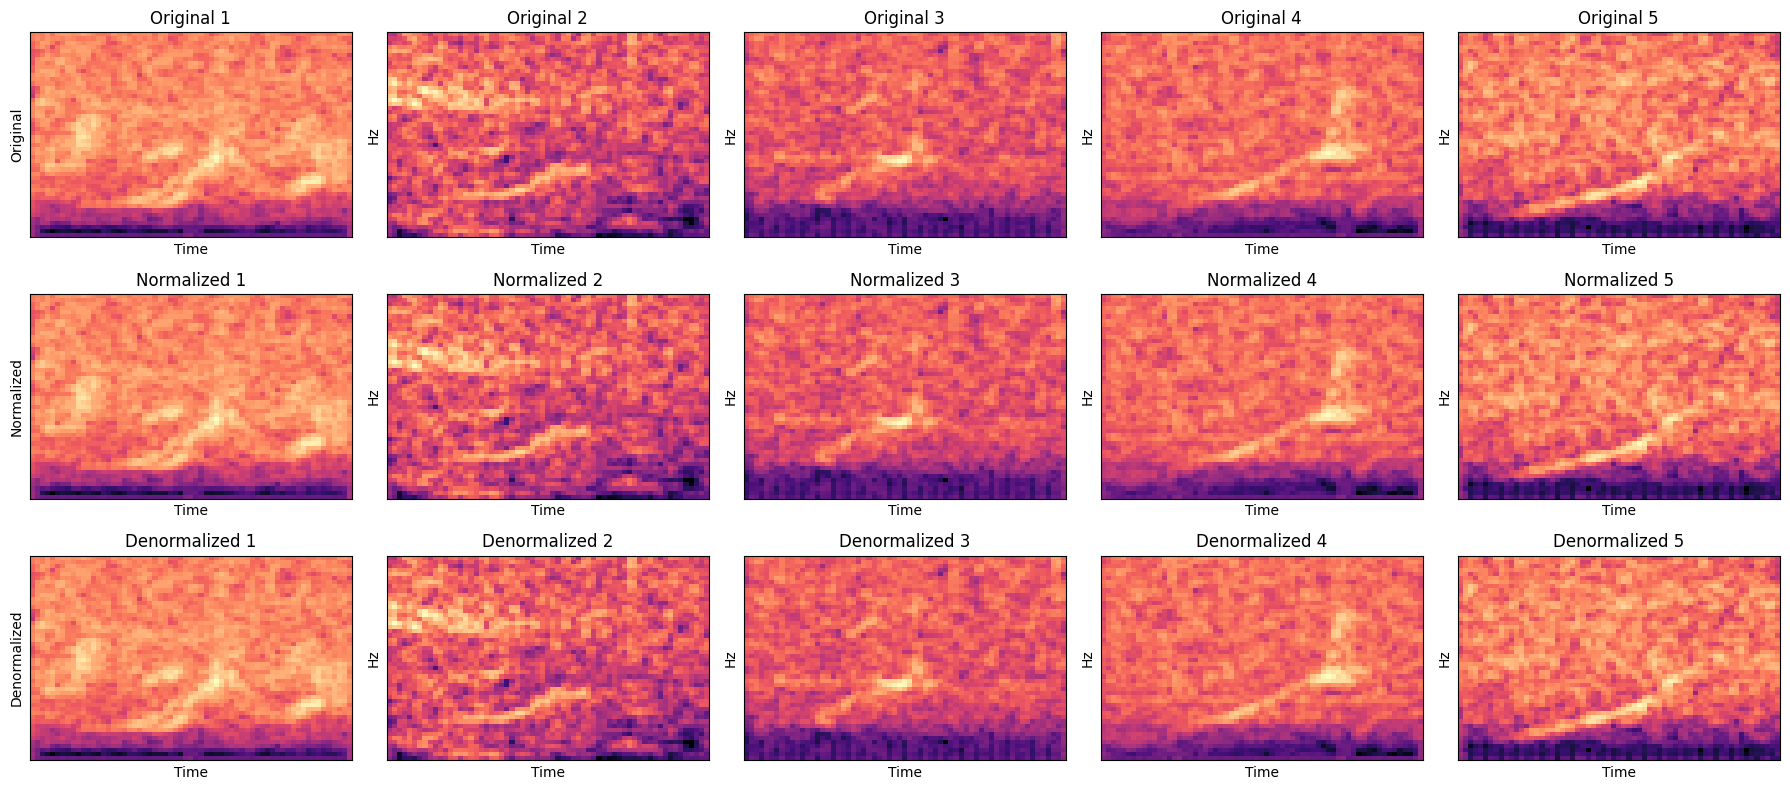

[[-33.229214 -35.363136 -46.20211  ... -38.63774  -44.521477 -44.579636]
 [-31.770988 -35.984596 -47.61613  ... -45.473064 -47.508736 -40.41755 ]
 [-34.700462 -42.51068  -47.163517 ... -44.19282  -45.98033  -42.610966]
 ...
 [-19.65347  -15.755347 -13.980202 ... -19.827393 -22.101807 -26.595238]
 [-20.521988 -16.33151  -13.673589 ... -15.751569 -22.518307 -23.939087]
 [-17.511944 -17.097256 -12.495781 ... -15.380875 -18.713755 -22.98985 ]]
[[0.58463484 0.5579608  0.4224736  ... 0.5170282  0.44348153 0.44275457]
 [0.60286266 0.55019253 0.40479836 ... 0.43158668 0.4061408  0.49478063]
 [0.56624424 0.4686165  0.41045603 ... 0.44758973 0.42524585 0.46736294]
 ...
 [0.75433165 0.80305815 0.82524747 ... 0.75215757 0.7237274  0.6675595 ]
 [0.74347514 0.7958561  0.8290801  ... 0.80310535 0.7185212  0.70076144]
 [0.7811007  0.7862843  0.84380275 ... 0.8077391  0.7660781  0.7126269 ]]
[[-33.229214 -35.363136 -46.20211  ... -38.63774  -44.521477 -44.579636]
 [-31.770988 -35.984596 -47.61613  ... 

In [57]:
def run_experiment_preview_spectrograms():
    # EXPERIMENTO [ NO BORRAR ]

    # Preparo los espectrogramas para enchufarselos al vae
    #   - grafico 5 muestras pre y post normalizar
    print(audio_df)

    original_spec_samples = []
    normalized_samples = []
    denormalized_samples = []

    global_min, global_max = compute_global_min_max(audio_df)

    whale_audio_samples = audio_df[audio_df['label'] == 1].sample(5)['audio']

    for sample in whale_audio_samples:
        mel_spec = get_melspectrogram(sample)
        original_spec_samples.append(mel_spec)

        normalized_mel_spec = normalize_spectrogram(mel_spec, global_min, global_max)
        normalized_samples.append(normalized_mel_spec)

        denormalized_mel_spec = denormalize_spectrogram(normalized_mel_spec, global_min, global_max)
        denormalized_samples.append(denormalized_mel_spec)

    fig, axes = plt.subplots(3, 5, figsize=(18, 8))

    for i in range(5):
        # Original spectrogram
        img0 = librosa.display.specshow(original_spec_samples[i], sr=SR, hop_length=HOP_LENGTH, ax=axes[0, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])

        # Normalized spectrogram
        img1 = librosa.display.specshow(normalized_samples[i], sr=SR, hop_length=HOP_LENGTH, ax=axes[1, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[1, i].set_title(f'Normalized {i+1}')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        # Denormalized spectrogram
        img2 = librosa.display.specshow(denormalized_samples[i], sr=SR, hop_length=HOP_LENGTH, ax=axes[2, i], x_axis='time', y_axis='hz', cmap='magma', fmax=MAX_FREQ)
        axes[2, i].set_title(f'Denormalized {i+1}')
        axes[2, i].set_xticks([])
        axes[2, i].set_yticks([])

    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Normalized')
    axes[2, 0].set_ylabel('Denormalized')
    plt.tight_layout()
    plt.show()

    print(original_spec_samples[-1])
    print(normalized_samples[-1])
    print(denormalized_samples[-1])

# run_experiment_preview_spectrograms()



### Obtenemos los espectrogramas de todos los audios y los normalizamos

In [24]:
global_min, global_max = compute_global_min_max(audio_df)
mel_specs = []
for whale_audio in audio_df[audio_df['label'] == 1]['audio']:
    mel = get_melspectrogram(whale_audio)
    mel_norm = normalize_spectrogram(mel, global_min, global_max)
    mel_specs.append(mel_norm.flatten())
X = np.array(mel_specs)

### Preparamos los datos para darselos al VAE

In [25]:
X = np.array(mel_specs)
X_tensor = torch.tensor(X, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_tensor), batch_size=128, shuffle=True)

### Entrenamos el VAE y generamos muestras sintéticas

In [70]:
# TRAIN
# vae, val_loss = train_vae_model(
#     X,
#     train_loader,
#     latent_dim=16,
#     decoder_layers=[256, 128],
#     activation_fn=nn.LeakyReLU,
#     lr=1e-3,
#     weight_decay=1e-4,
#     epochs=100,
#     patience=10
# )


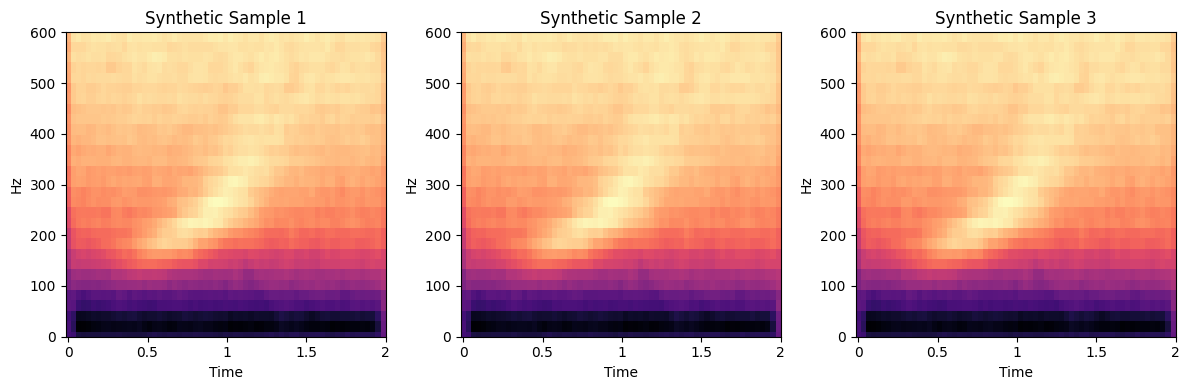

In [ ]:
def generate_synthetic_spectrograms(vae, num_samples, latent_dim, global_min, global_max):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = vae.decode(z).cpu().numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

    for i in range(num_samples):
        spec_norm = generated[i].reshape((N_MELS, -1))
        spec = denormalize_spectrogram(spec_norm, global_min, global_max)
        librosa.display.specshow(spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='hz',
                                 cmap='magma', ax=axes[i], fmax=MAX_FREQ)
        axes[i].set_title(f"Synthetic Sample {i+1}")
        axes[i].set_ylim([0, MAX_FREQ])

    plt.tight_layout()
    plt.show()

    return generated
num_samples = 3
latent_dim = 16

# generated = generate_synthetic_spectrograms(vae, num_samples, latent_dim, global_min, global_max)


In [28]:
def play_synthetic_samples(generated, global_min, global_max, num_samples):
    for i in range(num_samples):
        spec_norm = generated[i].reshape((N_MELS, -1))
        spec = denormalize_spectrogram(spec_norm, global_min, global_max)
        spec_power = librosa.db_to_power(spec)
        audio = librosa.feature.inverse.mel_to_audio(
            spec_power,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_iter=32,
            fmax=MAX_FREQ
        )
        print(f"Synthetic Sample {i+1}:")
        display(Audio(audio, rate=SR * 1.5))
# play_synthetic_samples(generated, global_min, global_max, num_samples)

### Buscamos hiperparámetros óptimos para el VAE

In [ ]:
from sklearn.model_selection import KFold
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset

def objective(trial):
    # Espacios de hiperparámetros
    latent_dim = trial.suggest_int("latent_dim", 2, 128, step=2)
    encoder_layers = trial.suggest_categorical("encoder_layers", [(256,), (512,), (512, 256), (1024, 512, 256)])
    decoder_layers = trial.suggest_categorical("decoder_layers", [(256,), (512,), (256, 512), (256, 512, 1024)])
    activation_fn_name = trial.suggest_categorical("activation_fn", ["ReLU", "LeakyReLU", "ELU", "sigmoid", "tanh"])
    activation_fn = getattr(nn, activation_fn_name)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    
    # Validación cruzada
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    val_losses = []

    for train_idx, val_idx in kf.split(X):
        # Dividir los datos en entrenamiento y validación
        train_dataset = Subset(TensorDataset(torch.tensor(X, dtype=torch.float32)), train_idx)
        val_dataset = Subset(TensorDataset(torch.tensor(X, dtype=torch.float32)), val_idx)
        
        train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
        
        # Entrenar el modelo
        vae, best_loss = train_vae_model(
            X=X,
            train_loader=train_loader,
            latent_dim=latent_dim,
            encoder_layers=encoder_layers,
            decoder_layers=decoder_layers,
            activation_fn=activation_fn,
            lr=lr,
            weight_decay=weight_decay,
            epochs=50,
            patience=10,
            verbose=False
        )
        
        # Asignar modelo al dispositivo
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        vae.to(device)

        # Evaluación en el conjunto de validación
        vae.eval()
        val_loss = 0
        with torch.no_grad():
            for xb_tuple in val_loader:
                xb = xb_tuple[0].to(device)  # Enviar datos al dispositivo
                x_hat, mu, logvar = vae(xb)
                val_loss += vae.loss(xb, x_hat, mu, logvar).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
    
    # Promediar la pérdida de validación de los pliegues
    return sum(val_losses) / len(val_losses)

# Crear y ejecutar la optimización
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Resultados finales
print(f"Best hyperparameters: {study.best_params}")
print(f"Best validation loss: {study.best_value:.4f}")


[I 2025-06-18 12:38:35,507] A new study created in memory with name: no-name-7c62cceb-6cef-4b23-aa11-db6d74c5ff7b
[W 2025-06-18 12:43:48,692] Trial 0 failed with parameters: {'latent_dim': 98, 'encoder_layers': (512, 256), 'decoder_layers': (256, 512, 1024), 'activation_fn': 'ReLU', 'lr': 1.8275154161470214e-05, 'weight_decay': 7.032759059249582e-06} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\bianc\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\bianc\AppData\Local\Temp\ipykernel_740\3339750243.py", line 31, in objective
    vae, best_loss = train_vae_model(
                     ^^^^^^^^^^^^^^^^
  File "C:\Users\bianc\AppData\Local\Temp\ipykernel_740\1536655718.py", line 86, in train_vae_model
    optimizer.step()
  File "c:\Users\bianc\AppData\Local\Programs\Python\Python311\Lib\

KeyboardInterrupt: 

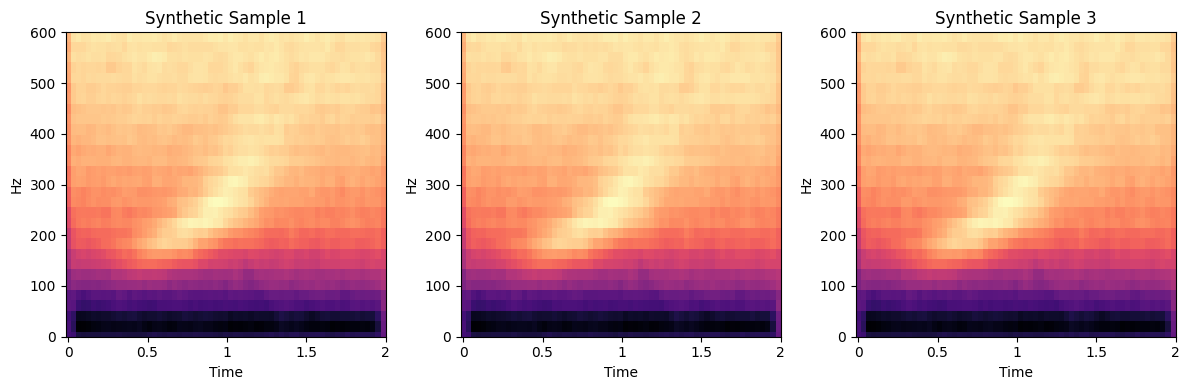

In [ ]:
def generate_synthetic_spectrograms(vae, num_samples, latent_dim, global_min, global_max):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)
        generated = vae.decode(z).cpu().numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

    for i in range(num_samples):
        spec_norm = generated[i].reshape((N_MELS, -1))
        spec = denormalize_spectrogram(spec_norm, global_min, global_max)
        librosa.display.specshow(spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='hz',
                                 cmap='magma', ax=axes[i], fmax=MAX_FREQ)
        axes[i].set_title(f"Synthetic Sample {i+1}")
        axes[i].set_ylim([0, MAX_FREQ])

    plt.tight_layout()
    plt.show()

    return generated
num_samples = 3
latent_dim = 16

# generated = generate_synthetic_spectrograms(vae, num_samples, latent_dim, global_min, global_max)


In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Función para obtener las representaciones latentes
def obtener_latentes(val_loader, vae, device):
    vae.eval()
    all_mu = []
    all_labels = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            mu, _ = vae.encode(xb)
            all_mu.append(mu.cpu().numpy())
            all_labels.append(yb.numpy())
    
    all_mu = np.concatenate(all_mu, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_mu, all_labels

# Función para aplicar PCA o t-SNE y visualizar
def visualizar_latente(val_loader, vae, device, metodo='PCA', random_state=None):
    # Obtener las representaciones latentes
    all_mu, all_labels = obtener_latentes(val_loader, vae, device)

    # Aplicar PCA o t-SNE
    if metodo == 'PCA':
        z_latente = PCA(n_components=2).fit_transform(all_mu)
        titulo = "VAE Latent Space (PCA)"
        xlabel, ylabel = "PC 1", "PC 2"
    elif metodo == 't-SNE':
        z_latente = TSNE(n_components=2, random_state=random_state).fit_transform(all_mu)
        titulo = "VAE Latent Space (t-SNE)"
        xlabel, ylabel = "t-SNE 1", "t-SNE 2"
    else:
        raise ValueError("Método debe ser 'PCA' o 't-SNE'.")

    # Graficar
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_latente[:, 0], z_latente[:, 1], c=all_labels, cmap='coolwarm', alpha=0.7)
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar(scatter, label="Clase")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Llamada a la función para PCA
# visualizar_latente(val_loader, vae, device, metodo='PCA')


In [31]:
# Llamada a la función para t-SNE
# visualizar_latente(val_loader, vae, device, metodo='t-SNE', random_state=SEED)

### Visualizacion de espacio latente con 2 VAEs y CVAE

In [32]:
# === ASUMIMOS ESTO HECHO ANTES (NO SE TOCA) ===
# global_min, global_max definidos
# X_tensor contiene solo espectros de ballenas (label == 1)
# train_loader = DataLoader(TensorDataset(X_tensor))

# === ARMAR DATOS COMPLETOS (ballena + no-ballena) ===
mel_specs_ballenas = []
mel_specs_no_ballenas = []

for _, row in audio_df.iterrows():
    mel = get_melspectrogram(row['audio'])
    mel_norm = normalize_spectrogram(mel, global_min, global_max)
    mel_flat = mel_norm.flatten()

    if row['label'] == 1:
        mel_specs_ballenas.append(mel_flat)
    else:
        mel_specs_no_ballenas.append(mel_flat)

X_ballenas = np.array(mel_specs_ballenas)
X_noballenas = np.array(mel_specs_no_ballenas)

X_total = np.vstack([X_ballenas, X_noballenas])
y_total = np.array([1]*len(X_ballenas) + [0]*len(X_noballenas))

# Tensores para PyTorch
X_tensor_total = torch.tensor(X_total, dtype=torch.float32)
y_tensor_total = torch.tensor(y_total, dtype=torch.float32).reshape(-1, 1)

# === DATALOADERS ===
train_loader_ballenas = DataLoader(TensorDataset(torch.tensor(X_ballenas, dtype=torch.float32)), batch_size=128, shuffle=True)
train_loader_total = DataLoader(TensorDataset(X_tensor_total, y_tensor_total), batch_size=128, shuffle=True)

In [34]:
import copy
# === DEFINICIÓN CVAE ===
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32, cond_dim=1):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x, y):
        x_in = torch.cat([x, y], dim=1)
        h = self.encoder(x_in)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def decode(self, z, y):
        z_in = torch.cat([z, y], dim=1)
        return self.decoder(z_in)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, y)
        return x_hat, mu, logvar

    def loss(self, x, x_hat, mu, logvar):
        recon = nn.functional.mse_loss(x_hat, x, reduction='mean')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon + kl

# === ENTRENAR CVAE con early stopping ===
def train_cvae(cvae, train_loader, patience=5, max_epochs=50):
    optimizer = optim.Adam(cvae.parameters(), lr=1e-3)
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(max_epochs):
        cvae.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            x_hat, mu, logvar = cvae(xb, yb)
            loss = cvae.loss(xb, x_hat, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * xb.size(0)

        avg_loss = total_loss / len(train_loader.dataset)
        print(f"[CVAE] Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = copy.deepcopy(cvae.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[CVAE] Early stopping at epoch {epoch+1}")
                break

    cvae.load_state_dict(best_model)

# === ENTRENAR VAEs SEPARADOS con early stopping ===
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def loss(self, x, x_hat, mu, logvar):
        recon = nn.functional.mse_loss(x_hat, x, reduction='mean')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon + kl

def train_vae(vae, X_data, name, patience=5, max_epochs=50):
    loader = DataLoader(TensorDataset(torch.tensor(X_data, dtype=torch.float32)), batch_size=128, shuffle=True)
    opt = optim.Adam(vae.parameters(), lr=1e-3)
    best_loss = float('inf')
    epochs_no_improve = 0
    best_model = None

    for epoch in range(max_epochs):
        vae.train()
        total_loss = 0
        for (xb,) in loader:
            xb = xb.to(device)
            x_hat, mu, logvar = vae(xb)
            loss = vae.loss(xb, x_hat, mu, logvar)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item() * xb.size(0)

        avg_loss = total_loss / len(loader.dataset)
        print(f"[VAE {name}] Epoch {epoch+1}, Loss: {avg_loss:.4f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = copy.deepcopy(vae.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"[VAE {name}] Early stopping at epoch {epoch+1}")
                break

    vae.load_state_dict(best_model)

# === Ejecución ===
cvae = CVAE(X_total.shape[1], latent_dim=32).to(device)
# train_cvae(cvae, train_loader_total)

vae_ballena = VAE(X_ballenas.shape[1], latent_dim=32).to(device)
vae_noballena = VAE(X_noballenas.shape[1], latent_dim=32).to(device)

# train_vae(vae_ballena, X_ballenas, "ballena")
# train_vae(vae_noballena, X_noballenas, "no-ballena")


In [35]:
# === REPRESENTACIONES LATENTES ===
def get_latents(vae, X):
    vae.eval()
    mus = []
    loader = DataLoader(torch.tensor(X, dtype=torch.float32), batch_size=128)
    with torch.no_grad():
        for xb in loader:
            xb = xb.to(device)
            mu, _ = vae.encode(xb)
            mus.append(mu.cpu().numpy())
    return np.vstack(mus)

with torch.no_grad():
    mu_cvae, _ = cvae.encode(X_tensor_total.to(device), y_tensor_total.to(device))
mu_cvae = mu_cvae.cpu().numpy()

mu_ballena = get_latents(vae_ballena, X_ballenas)
mu_noballena = get_latents(vae_noballena, X_noballenas)
mu_2vae = np.vstack([mu_ballena, mu_noballena])
y_2vae = np.array([1]*len(mu_ballena) + [0]*len(mu_noballena))

# === VISUALIZACIÓN ===
def plot_latente(z, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z[:, 0], z[:, 1], c=y, cmap='coolwarm', alpha=0.7)
    plt.colorbar(scatter, label="Clase")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# z_cvae_pca = PCA(2).fit_transform(mu_cvae)
# z_cvae_tsne = TSNE(2, random_state=42).fit_transform(mu_cvae)
# plot_latente(z_cvae_pca, y_total, "CVAE Latent Space (PCA)")
# plot_latente(z_cvae_tsne, y_total, "CVAE Latent Space (t-SNE)")

# z_2vae_pca = PCA(2).fit_transform(mu_2vae)
# z_2vae_tsne = TSNE(2, random_state=42).fit_transform(mu_2vae)
# plot_latente(z_2vae_pca, y_2vae, "Dos VAEs Latent Space (PCA)")
# plot_latente(z_2vae_tsne, y_2vae, "Dos VAEs Latent Space (t-SNE)")


### Entrenamos un Generative Adversarial Network (GAN)
Necesitamo otro prepro

In [80]:
global_min, global_max = compute_global_min_max(audio_df)

mel_specs = []
labels = []  # Para mantener track de las clases

for _, row in audio_df.iterrows():
    mel = get_melspectrogram(row['audio'])
    mel_norm = normalize_spectrogram(mel, global_min, global_max)
    mel_specs.append(mel_norm.flatten())
    labels.append(row['label'])  # Guardar la etiqueta correspondiente

# Convertir a numpy arrays
X = np.array(mel_specs)
y = np.array(labels)

# Crear tensores de datos
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)  # Etiquetas como flotantes para BCEWithLogits

# Crear DataLoader con etiquetas
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=128, shuffle=True)


Cargamos modelo polenta como discriminante

In [69]:
import sys
sys.path.append(r"C:\Users\bianc\Machine\TPFINAL\whale_detector")
from netDefinition import Net
from torch.serialization import add_safe_globals

# Registrar la clase Net para deserialización
add_safe_globals([Net])

# === 1. Cargar modelo preentrenado ===
discriminator = torch.load(
    "C:\\Users\\bianc\\Machine\\TPFINAL\\whale_detector\\endTrain_savedNet",
    map_location="cpu",
    weights_only=False,
)
discriminator.eval()

Net(
  (root): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (b_1x1): Sequential(
    (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (b_3x3): Sequential(
    (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplac

### Ahora si entrenamo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# === 1. Definir el Generador ===
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, z):
        return self.model(z)

# === 2. Entrenamiento del GAN ===
def train_gan_with_pretrained_discriminator(train_loader, latent_dim=32, epochs=100, lambda_recon=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dimensiones esperadas por el discriminador
    canales, altura, ancho = 1, 64, 64  # Cambiar según los datos
    output_dim = canales * altura * ancho

    # Inicializar el Generador
    generator = Generator(latent_dim, output_dim).to(device)
    generator.train()

    # Asegurar que el discriminador esté congelado
    discriminator.eval()
    for param in discriminator.parameters():
        param.requires_grad = False

    # Funciones de pérdida
    bce = nn.BCEWithLogitsLoss()
    mse = nn.MSELoss()

    # Optimizador
    opt_g = optim.Adam(generator.parameters(), lr=1e-4)

    for epoch in range(epochs):
        total_g_loss = 0

        for xb_tuple in train_loader:
            xb = xb_tuple[0].to(device)  # Datos reales
            batch_size = xb.size(0)

            # Reformatear los datos reales a la forma esperada por el discriminador
            xb = xb.view(batch_size, 1, 64, 64)  # Asegúrate de usar las dimensiones correctas

            # Generar datos falsos
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z).view(batch_size, 1, 64, 64)

            # Evaluar con el discriminador
            with torch.no_grad():
                d_real = discriminator(xb)
                d_fake = discriminator(fake_data)


            # Pérdidas
            real_labels = torch.ones_like(d_real)
            g_adv = bce(d_fake, real_labels)  # El generador intenta engañar al discriminador
            g_recon = mse(fake_data.view(batch_size, -1), xb.view(batch_size, -1))  # Reconstrucción
            g_loss = g_adv + lambda_recon * g_recon

            # Optimización del generador
            opt_g.zero_grad()
            g_loss.backward()
            opt_g.step()

            total_g_loss += g_loss.item() * batch_size

        avg_g_loss = total_g_loss / len(train_loader.dataset)
        print(f"Epoch {epoch + 1}/{epochs} | Generator Loss: {avg_g_loss:.4f}")

    return generator

# === 3. Entrenamiento del GAN ===
latent_dim = 32  # Dimensión del espacio latente
generator = train_gan_with_pretrained_discriminator(train_loader, latent_dim=latent_dim, epochs=100)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [128, 3150]

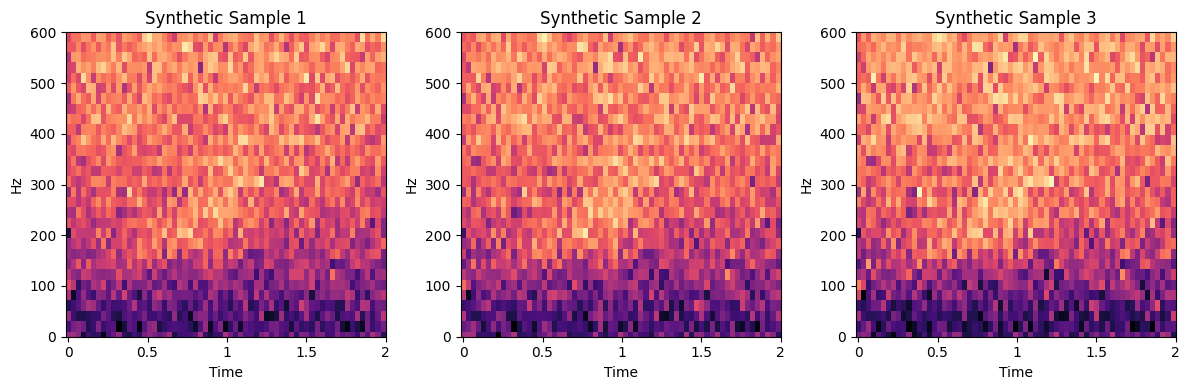

In [72]:
def generate_synthetic_spectrograms_gan(generator, num_samples, latent_dim, global_min, global_max):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        generated = generator(z).cpu().numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

    for i in range(num_samples):
        spec_norm = generated[i].reshape((N_MELS, -1))
        spec = denormalize_spectrogram(spec_norm, global_min, global_max)
        librosa.display.specshow(spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='hz',
                                 cmap='magma', ax=axes[i], fmax=MAX_FREQ)
        axes[i].set_title(f"Synthetic Sample {i+1}")
        axes[i].set_ylim([0, MAX_FREQ])

    plt.tight_layout()
    plt.show()

    return generated

# Parámetros
latent_dim = 32
num_samples = 3

# Generación de espectrogramas sintéticos
generated_spectrograms = generate_synthetic_spectrograms_gan(
    generator=generator,
    num_samples=num_samples,
    latent_dim=latent_dim,
    global_min=global_min,
    global_max=global_max
)


In [39]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

class AAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

def train_aae_model(X, train_loader, latent_dim=32, epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X.shape[1]

    aae = AAE(input_dim, latent_dim).to(device)
    D = Discriminator(latent_dim).to(device)

    opt_ae = optim.Adam(list(aae.encoder.parameters()) + list(aae.decoder.parameters()), lr=1e-3)
    opt_d = optim.Adam(D.parameters(), lr=1e-3)
    opt_g = optim.Adam(aae.encoder.parameters(), lr=1e-3)

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()

    for epoch in range(epochs):
        aae.train()
        total_ae_loss, total_d_loss, total_g_loss = 0, 0, 0

        for xb_tuple in train_loader:
            xb = xb_tuple[0].to(device)

            # === Reconstruction phase ===
            x_hat, z = aae(xb)
            recon_loss = mse_loss(x_hat, xb)
            opt_ae.zero_grad()
            recon_loss.backward()
            opt_ae.step()

            # === Discriminator phase ===
            z_real = torch.randn_like(z).to(device)
            z_fake = z.detach()
            d_real = D(z_real)
            d_fake = D(z_fake)
            d_loss = bce_loss(d_real, torch.ones_like(d_real)) + \
                     bce_loss(d_fake, torch.zeros_like(d_fake))
            opt_d.zero_grad()
            d_loss.backward()
            opt_d.step()

            # === Generator (Encoder) phase ===
            z_fake = aae.encoder(xb)
            d_fake = D(z_fake)
            g_loss = bce_loss(d_fake, torch.ones_like(d_fake))
            opt_g.zero_grad()
            g_loss.backward()
            opt_g.step()

            total_ae_loss += recon_loss.item() * xb.size(0)
            total_d_loss += d_loss.item() * xb.size(0)
            total_g_loss += g_loss.item() * xb.size(0)

        n = len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - Recon: {total_ae_loss/n:.4f} | D: {total_d_loss/n:.4f} | G: {total_g_loss/n:.4f}")

    return aae

aae = train_aae_model(X, train_loader, latent_dim=32, epochs=50)


Epoch 1/50 - Recon: 0.0150 | D: 1.3275 | G: 1.0234
Epoch 2/50 - Recon: 0.0071 | D: 1.6428 | G: 1.0744
Epoch 3/50 - Recon: 0.0074 | D: 1.4822 | G: 1.0284
Epoch 4/50 - Recon: 0.0087 | D: 1.0892 | G: 0.6295
Epoch 5/50 - Recon: 0.0085 | D: 0.6284 | G: 1.0998
Epoch 6/50 - Recon: 0.0085 | D: 0.3563 | G: 1.5853
Epoch 7/50 - Recon: 0.0085 | D: 0.2431 | G: 2.0323
Epoch 8/50 - Recon: 0.0085 | D: 0.1045 | G: 2.9501
Epoch 9/50 - Recon: 0.0085 | D: 0.0655 | G: 3.6167
Epoch 10/50 - Recon: 0.0086 | D: 0.0526 | G: 3.8327
Epoch 11/50 - Recon: 0.0085 | D: 0.0346 | G: 4.2633
Epoch 12/50 - Recon: 0.0085 | D: 0.0238 | G: 4.6279
Epoch 13/50 - Recon: 0.0086 | D: 0.0186 | G: 4.8175
Epoch 14/50 - Recon: 0.0085 | D: 0.0183 | G: 4.8697
Epoch 15/50 - Recon: 0.0085 | D: 0.0156 | G: 4.9549
Epoch 16/50 - Recon: 0.0085 | D: 0.0121 | G: 5.2190
Epoch 17/50 - Recon: 0.0085 | D: 0.0101 | G: 5.3630
Epoch 18/50 - Recon: 0.0085 | D: 0.0086 | G: 5.4922
Epoch 19/50 - Recon: 0.0085 | D: 0.0083 | G: 5.4721
Epoch 20/50 - Recon: 

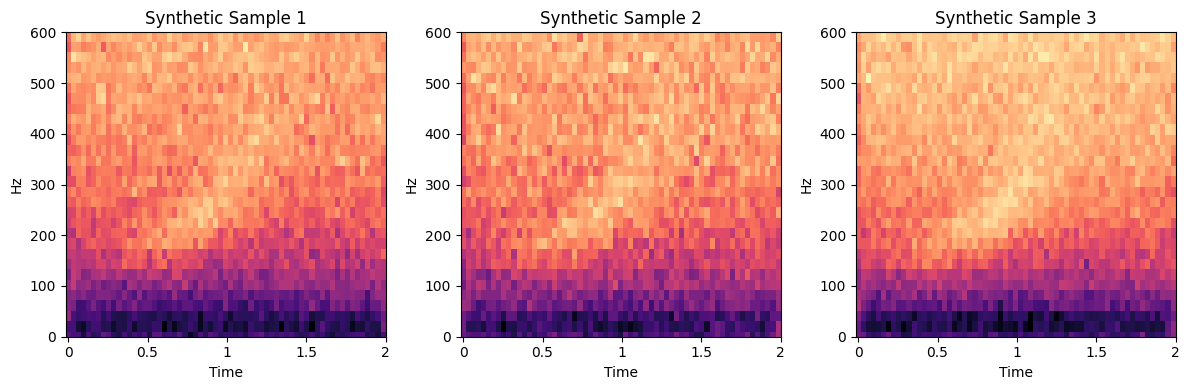

In [40]:
def generate_synthetic_spectrograms(aae, num_samples, latent_dim, global_min, global_max):
    aae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(next(aae.parameters()).device)
        generated = aae.decoder(z).cpu().numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
    for i in range(num_samples):
        spec_norm = generated[i].reshape((N_MELS, -1))
        spec = denormalize_spectrogram(spec_norm, global_min, global_max)
        librosa.display.specshow(spec, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='hz',
                                 cmap='magma', ax=axes[i], fmax=MAX_FREQ)
        axes[i].set_title(f"Synthetic Sample {i+1}")
        axes[i].set_ylim([0, MAX_FREQ])
    plt.tight_layout()
    plt.show()

    return generated
generated = generate_synthetic_spectrograms(aae, num_samples=3, latent_dim=32, 
                                            global_min=global_min, global_max=global_max)


Epoch 1/50 - Recon: 0.0125 | D: 2.0778 | G: 0.7040
Epoch 2/50 - Recon: 0.0073 | D: 1.4815 | G: 1.0604
Epoch 3/50 - Recon: 0.0106 | D: 1.4574 | G: 0.7094
Epoch 4/50 - Recon: 0.0086 | D: 0.8999 | G: 0.8805
Epoch 5/50 - Recon: 0.0085 | D: 0.4903 | G: 1.3655
Epoch 6/50 - Recon: 0.0085 | D: 0.2455 | G: 2.2115
Epoch 7/50 - Recon: 0.0086 | D: 0.1160 | G: 3.1108
Epoch 8/50 - Recon: 0.0085 | D: 0.0760 | G: 3.4133
Epoch 9/50 - Recon: 0.0085 | D: 0.0501 | G: 3.9191
Epoch 10/50 - Recon: 0.0085 | D: 0.0326 | G: 4.3080
Epoch 11/50 - Recon: 0.0085 | D: 0.0244 | G: 4.4176
Epoch 12/50 - Recon: 0.0085 | D: 0.0236 | G: 4.5004
Early stopping triggered.


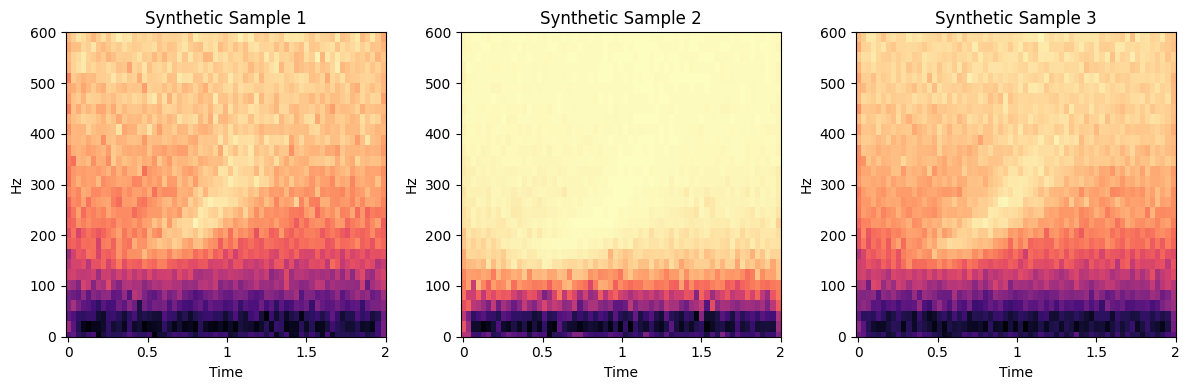

In [55]:
# === Modelos ===
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self, latent_dim, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.net(z)

class AAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

# === Entrenamiento con early stopping ===
def train_aae_model(X, train_loader, latent_dim=32, epochs=100, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X.shape[1]

    aae = AAE(input_dim, latent_dim).to(device)
    D = Discriminator(latent_dim).to(device)

    opt_ae = optim.Adam(list(aae.encoder.parameters()) + list(aae.decoder.parameters()), lr=1e-3)
    opt_d = optim.Adam(D.parameters(), lr=1e-3)
    opt_g = optim.Adam(aae.encoder.parameters(), lr=1e-3)

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()

    best_loss = float('inf')
    early_stop_counter = 0

    for epoch in range(epochs):
        aae.train()
        total_ae_loss, total_d_loss, total_g_loss = 0, 0, 0

        for xb_tuple in train_loader:
            xb = xb_tuple[0].to(device)

            # Reconstrucción
            x_hat, z = aae(xb)
            recon_loss = mse_loss(x_hat, xb)
            opt_ae.zero_grad()
            recon_loss.backward()
            opt_ae.step()

            # Discriminador
            z_real = torch.randn_like(z).to(device)
            z_fake = z.detach()
            d_real = D(z_real)
            d_fake = D(z_fake)
            d_loss = bce_loss(d_real, torch.ones_like(d_real)) + \
                     bce_loss(d_fake, torch.zeros_like(d_fake))
            opt_d.zero_grad()
            d_loss.backward()
            opt_d.step()

            # Generador (Encoder)
            z_fake = aae.encoder(xb)
            d_fake = D(z_fake)
            g_loss = bce_loss(d_fake, torch.ones_like(d_fake))
            opt_g.zero_grad()
            g_loss.backward()
            opt_g.step()

            total_ae_loss += recon_loss.item() * xb.size(0)
            total_d_loss += d_loss.item() * xb.size(0)
            total_g_loss += g_loss.item() * xb.size(0)

        n = len(train_loader.dataset)
        epoch_loss = total_ae_loss / n
        print(f"Epoch {epoch+1}/{epochs} - Recon: {epoch_loss:.4f} | D: {total_d_loss/n:.4f} | G: {total_g_loss/n:.4f}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    return aae

aae = train_aae_model(X, train_loader, latent_dim=32, epochs=50)
generated = generate_synthetic_spectrograms(aae, num_samples=3, latent_dim=32, 
                                            global_min=global_min, global_max=global_max)